## Required library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

In [185]:
description=pd.read_excel(r'D:\Downloads\variable_description.xlsx')
train=pd.read_excel(r'D:\Downloads\data.xlsx')

In [186]:
description

,Variables,Description
0,PLAYER,Name of the player
1,Mat,Matches played in IPL 2018
2,Inns,Innings batted in IPL 2018
3,NO,Number of Not Outs in IPL 2018
4,2018_Runs,Total Runs in IPL 2018
5,HS,Highest Score in IPL 2018
6,Avg,Batting Average in IPL 2018
7,BF,Total Balls Faced in the tournament
8,SR,Strike Rate in IPL 2018
9,100,Number of centuries in IPL 2018


## EDA 

In [187]:
train.sort_values(by="2018_Runs",ascending=False).head() #Top 5 scorer of ipl2018

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
42,Kane Williamson,17,17,3,735,84,52.5,516,142.44,0,8,64,28,692
73,Rishabh Pant,14,14,1,684,128*,52.61,394,173.60,1,5,68,37,593
46,KL Rahul,14,14,2,659,95*,54.91,416,158.41,0,6,66,32,529
5,Ambati Rayudu,16,16,2,602,100*,43,402,149.75,1,3,53,34,521
80,Shane Watson,15,15,1,555,117*,39.64,359,154.59,2,2,44,35,510


In [188]:
train.sort_values(by="2019_Runs",ascending=False).head() #They also rocked in 2019

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
42,Kane Williamson,17,17,3,735,84,52.5,516,142.44,0,8,64,28,692
73,Rishabh Pant,14,14,1,684,128*,52.61,394,173.60,1,5,68,37,593
46,KL Rahul,14,14,2,659,95*,54.91,416,158.41,0,6,66,32,529
5,Ambati Rayudu,16,16,2,602,100*,43,402,149.75,1,3,53,34,521
80,Shane Watson,15,15,1,555,117*,39.64,359,154.59,2,2,44,35,510


In [189]:
train.Avg=train.Avg.replace({'-':100}).astype(float)

In [190]:
train.head()

,PLAYER,Mat,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,2019_Runs
0,Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,0,6,8,160
1,AB de Villiers,12,11,2,480,90*,53.33,275,174.54,0,6,39,30,424
2,Abhishek Sharma,3,3,2,63,46*,63.00,33,190.90,0,0,3,5,63
3,Ajinkya Rahane,15,14,1,370,65*,28.46,313,118.21,0,1,39,5,396
4,Alex Hales,6,6,0,148,45,24.66,118,125.42,0,0,13,6,165


In [191]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PLAYER     100 non-null    object 
 1   Mat        100 non-null    int64  
 2   Inns       100 non-null    int64  
 3   NO         100 non-null    int64  
 4   2018_Runs  100 non-null    int64  
 5   HS         100 non-null    object 
 6   Avg        100 non-null    float64
 7   BF         100 non-null    int64  
 8   SR         100 non-null    float64
 9   100        100 non-null    int64  
 10  50         100 non-null    int64  
 11  4s         100 non-null    int64  
 12  6s         100 non-null    int64  
 13  2019_Runs  100 non-null    int64  
dtypes: float64(2), int64(10), object(2)
memory usage: 11.1+ KB


In [192]:
train.HS=train['HS'].map(str).str.replace('*','').astype(int)

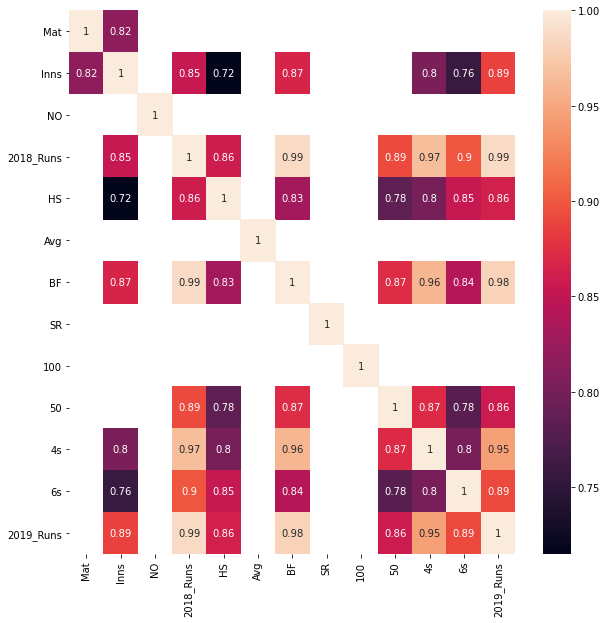

In [193]:
plt.figure(figsize=(10,10))
sns.heatmap(train.iloc[:,1:].corr()[train.iloc[:,1:].corr()>.7],annot=True)

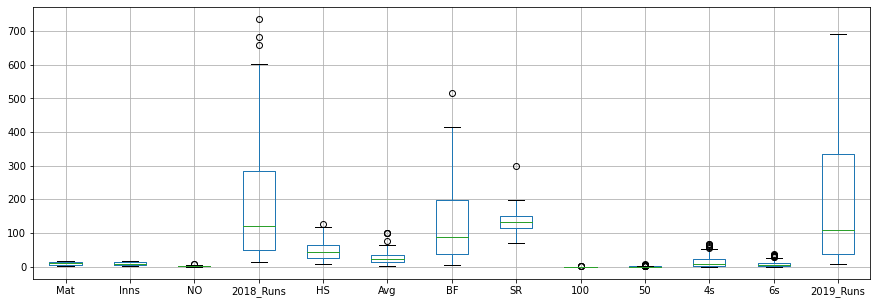

In [194]:
train.iloc[:,1:].boxplot(figsize=(15,5))

### Feature generation

In [195]:
train['Runs_by_boundry']=train['4s']*4+6*train['6s']
train['%Runs by boundry']=np.round(train.Runs_by_boundry/train['2018_Runs']*100,2)
train['Avg_b']=np.round(train.Runs_by_boundry/train.Inns,2)

## Model building.

In [196]:
feature=train.drop(['Mat','2019_Runs'],axis=1)
label=train['2019_Runs']

In [197]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

### CV
Along with the l1-mean, l1-std reduced in significant amount, it is indicating the lots of variation in the prediction,great thing. but it is somewhat indicative of overfit.

In [250]:
params={'objective':'regression_l1','learning_rate':.01,'max_depth':3,'subsample':.8,'sub_feature':.8,'max_bin':100,'metric':'mae'}
dtrain=lgb.Dataset(feature.iloc[:,1:],label)
pd.DataFrame(lgb.cv(params,dtrain,num_boost_round=1000,nfold=5,early_stopping_rounds=200,verbose_eval=10,stratified=False))

[10]	cv_agg's l1: 137.709 + 31.2305
[20]	cv_agg's l1: 125.139 + 30.2211
[30]	cv_agg's l1: 113.569 + 29.5083
[40]	cv_agg's l1: 103.048 + 28.7502
[50]	cv_agg's l1: 93.6604 + 28.1277
[60]	cv_agg's l1: 85.6947 + 27.277
[70]	cv_agg's l1: 78.3504 + 26.3293
[80]	cv_agg's l1: 71.9313 + 24.9087
[90]	cv_agg's l1: 66.0144 + 23.9425
[100]	cv_agg's l1: 60.675 + 22.8387
[110]	cv_agg's l1: 55.8304 + 21.7471
[120]	cv_agg's l1: 51.5427 + 20.8751
[130]	cv_agg's l1: 47.7937 + 20.0448
[140]	cv_agg's l1: 44.6062 + 19.1966
[150]	cv_agg's l1: 41.8353 + 18.7314
[160]	cv_agg's l1: 39.2405 + 18.3211
[170]	cv_agg's l1: 36.9347 + 17.779
[180]	cv_agg's l1: 35.007 + 17.3556
[190]	cv_agg's l1: 33.3422 + 16.9674
[200]	cv_agg's l1: 31.722 + 16.5188
[210]	cv_agg's l1: 30.4176 + 16.1584
[220]	cv_agg's l1: 29.2833 + 15.6825
[230]	cv_agg's l1: 28.4275 + 15.3117
[240]	cv_agg's l1: 27.7807 + 14.9158
[250]	cv_agg's l1: 27.016 + 14.5765
[260]	cv_agg's l1: 26.4786 + 14.3374
[270]	cv_agg's l1: 26.0221 + 14.3544
[280]	cv_agg's l

,l1-mean,l1-stdv
0,149.349700,31.284170
1,147.953503,31.337883
2,146.573227,31.395010
3,145.255659,31.421964
4,143.984211,31.414830
...,...,...
612,22.136410,11.655310
613,22.133987,11.651793
614,22.138576,11.644229
615,22.137047,11.645157


In [251]:
X_train,X_test,y_train,y_test=train_test_split(feature,label,random_state=101,test_size=.25)
dtrain=lgb.Dataset(X_train.iloc[:,1:],y_train)
dval=lgb.Dataset(X_test.iloc[:,1:],y_test)
lgb_cl=lgb.train(params,dtrain,num_boost_round=5000,early_stopping_rounds=300,valid_sets=[dtrain,dval])

[1]	training's l1: 142.088	valid_1's l1: 131.025
Training until validation scores don't improve for 300 rounds
[2]	training's l1: 140.678	valid_1's l1: 129.367
[3]	training's l1: 139.351	valid_1's l1: 127.902
[4]	training's l1: 137.962	valid_1's l1: 126.979
[5]	training's l1: 136.588	valid_1's l1: 125.546
[6]	training's l1: 135.312	valid_1's l1: 124.128
[7]	training's l1: 133.98	valid_1's l1: 123.241
[8]	training's l1: 132.661	valid_1's l1: 121.905
[9]	training's l1: 131.357	valid_1's l1: 120.661
[10]	training's l1: 130.071	valid_1's l1: 119.746
[11]	training's l1: 128.787	valid_1's l1: 118.443
[12]	training's l1: 127.519	valid_1's l1: 117.154
[13]	training's l1: 126.267	valid_1's l1: 115.878
[14]	training's l1: 124.947	valid_1's l1: 114.379
[15]	training's l1: 123.712	valid_1's l1: 113.652
[16]	training's l1: 122.491	valid_1's l1: 112.39
[17]	training's l1: 121.286	valid_1's l1: 111.152
[18]	training's l1: 120.095	valid_1's l1: 109.915
[19]	training's l1: 118.915	valid_1's l1: 109.228

[452]	training's l1: 20.8286	valid_1's l1: 14.3432
[453]	training's l1: 20.8278	valid_1's l1: 14.3445
[454]	training's l1: 20.827	valid_1's l1: 14.3446
[455]	training's l1: 20.8263	valid_1's l1: 14.3448
[456]	training's l1: 20.8241	valid_1's l1: 14.3398
[457]	training's l1: 20.8233	valid_1's l1: 14.3401
[458]	training's l1: 20.8226	valid_1's l1: 14.3404
[459]	training's l1: 20.822	valid_1's l1: 14.3407
[460]	training's l1: 20.8194	valid_1's l1: 14.3379
[461]	training's l1: 20.8175	valid_1's l1: 14.3412
[462]	training's l1: 20.8162	valid_1's l1: 14.3444
[463]	training's l1: 20.8159	valid_1's l1: 14.3451
[464]	training's l1: 20.8156	valid_1's l1: 14.3459
[465]	training's l1: 20.8153	valid_1's l1: 14.3466
[466]	training's l1: 20.8092	valid_1's l1: 14.3503
[467]	training's l1: 20.809	valid_1's l1: 14.3499
[468]	training's l1: 20.808	valid_1's l1: 14.3533
[469]	training's l1: 20.8053	valid_1's l1: 14.3488
[470]	training's l1: 20.8037	valid_1's l1: 14.3519
[471]	training's l1: 20.8024	valid_

[964]	training's l1: 19.7085	valid_1's l1: 12.7987
[965]	training's l1: 19.7083	valid_1's l1: 12.7856
[966]	training's l1: 19.7081	valid_1's l1: 12.7727
[967]	training's l1: 19.708	valid_1's l1: 12.7599
[968]	training's l1: 19.7077	valid_1's l1: 12.7596
[969]	training's l1: 19.7066	valid_1's l1: 12.7612
[970]	training's l1: 19.7065	valid_1's l1: 12.7608
[971]	training's l1: 19.7037	valid_1's l1: 12.7516
[972]	training's l1: 19.7026	valid_1's l1: 12.7547
[973]	training's l1: 19.6943	valid_1's l1: 12.7218
[974]	training's l1: 19.6914	valid_1's l1: 12.7243
[975]	training's l1: 19.6909	valid_1's l1: 12.7254
[976]	training's l1: 19.6904	valid_1's l1: 12.7274
[977]	training's l1: 19.6891	valid_1's l1: 12.7322
[978]	training's l1: 19.6864	valid_1's l1: 12.7391
[979]	training's l1: 19.6856	valid_1's l1: 12.7392
[980]	training's l1: 19.6849	valid_1's l1: 12.7392
[981]	training's l1: 19.6823	valid_1's l1: 12.746
[982]	training's l1: 19.6813	valid_1's l1: 12.7459
[983]	training's l1: 19.6789	vali

[1489]	training's l1: 18.6778	valid_1's l1: 12.583
[1490]	training's l1: 18.6763	valid_1's l1: 12.582
[1491]	training's l1: 18.6727	valid_1's l1: 12.5865
[1492]	training's l1: 18.669	valid_1's l1: 12.5812
[1493]	training's l1: 18.6653	valid_1's l1: 12.5759
[1494]	training's l1: 18.6616	valid_1's l1: 12.5707
[1495]	training's l1: 18.658	valid_1's l1: 12.5655
[1496]	training's l1: 18.6579	valid_1's l1: 12.5654
[1497]	training's l1: 18.6578	valid_1's l1: 12.5651
[1498]	training's l1: 18.6544	valid_1's l1: 12.56
[1499]	training's l1: 18.6543	valid_1's l1: 12.5598
[1500]	training's l1: 18.654	valid_1's l1: 12.5695
[1501]	training's l1: 18.6538	valid_1's l1: 12.5695
[1502]	training's l1: 18.6536	valid_1's l1: 12.5693
[1503]	training's l1: 18.6501	valid_1's l1: 12.5644
[1504]	training's l1: 18.649	valid_1's l1: 12.5673
[1505]	training's l1: 18.6455	valid_1's l1: 12.5624
[1506]	training's l1: 18.6443	valid_1's l1: 12.5625
[1507]	training's l1: 18.6409	valid_1's l1: 12.5576
[1508]	training's l1

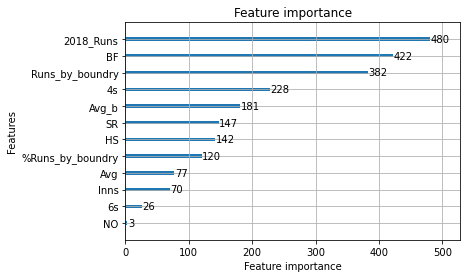

In [252]:
lgb.plot_importance(lgb_cl)

In [253]:
train['2019_Runs'].std(),lgb_cl.predict(feature.iloc[:,1:]).std() #Nearlly equal. war: Be carefull to overfit.

(173.30930019867236, 156.6889062965388)

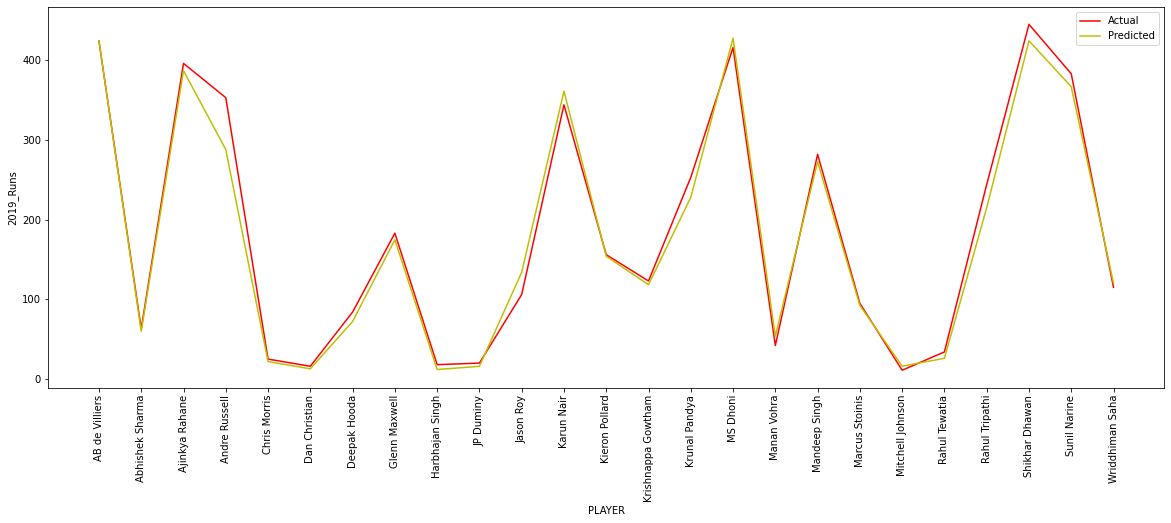

In [254]:
plt.figure(figsize=(20,7))
sns.lineplot(x=X_test.PLAYER,y=y_test,color='r',label='Actual')
plt.xticks(rotation=90)
sns.lineplot(x=X_test.PLAYER,y=lgb_cl.predict(X_test.iloc[:,1:]),color='y',label='Predicted')
plt.legend()

In [255]:
feature.isnull().sum()

PLAYER              0
Inns                0
NO                  0
2018_Runs           0
HS                  0
Avg                 0
BF                  0
SR                  0
100                 0
50                  0
4s                  0
6s                  0
Runs_by_boundry     0
%Runs by boundry    0
Avg_b               0
dtype: int64

### Linear model

In [256]:
feature.head()

,PLAYER,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,Runs_by_boundry,%Runs by boundry,Avg_b
0,Aaron Finch,9,1,134,46,16.75,100,134.00,0,0,6,8,72,53.73,8.00
1,AB de Villiers,11,2,480,90,53.33,275,174.54,0,6,39,30,336,70.00,30.55
2,Abhishek Sharma,3,2,63,46,63.00,33,190.90,0,0,3,5,42,66.67,14.00
3,Ajinkya Rahane,14,1,370,65,28.46,313,118.21,0,1,39,5,186,50.27,13.29
4,Alex Hales,6,0,148,45,24.66,118,125.42,0,0,13,6,88,59.46,14.67


In [258]:
ss=StandardScaler()
ss.fit(X_train.iloc[:,1:])
lr=Lasso()

lr.fit(ss.transform(X_train.iloc[:,1:]),y_train)

Lasso()

In [260]:
mean_absolute_error(y_test,lr.predict(ss.transform(X_test.iloc[:,1:])))

17.89749233414183

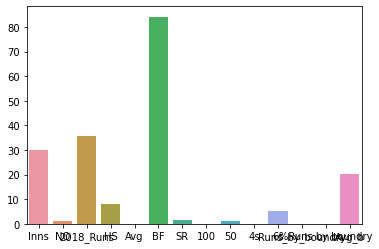

In [261]:
sns.barplot(x=feature.iloc[:,1:].columns,y=lr.coef_)

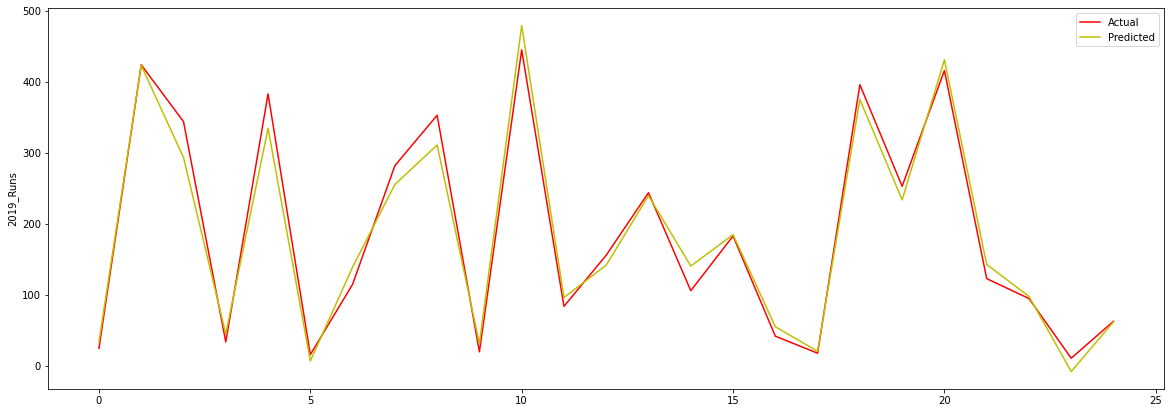

In [263]:
plt.figure(figsize=(20,7))
sns.lineplot(x=range(len(X_test)),y=y_test,color='r',label='Actual')
sns.lineplot(x=range(len(X_test)),y=lr.predict(ss.transform(X_test.iloc[:,1:])),color='y',label='Predicted')
plt.legend()

### 50-50 of both model

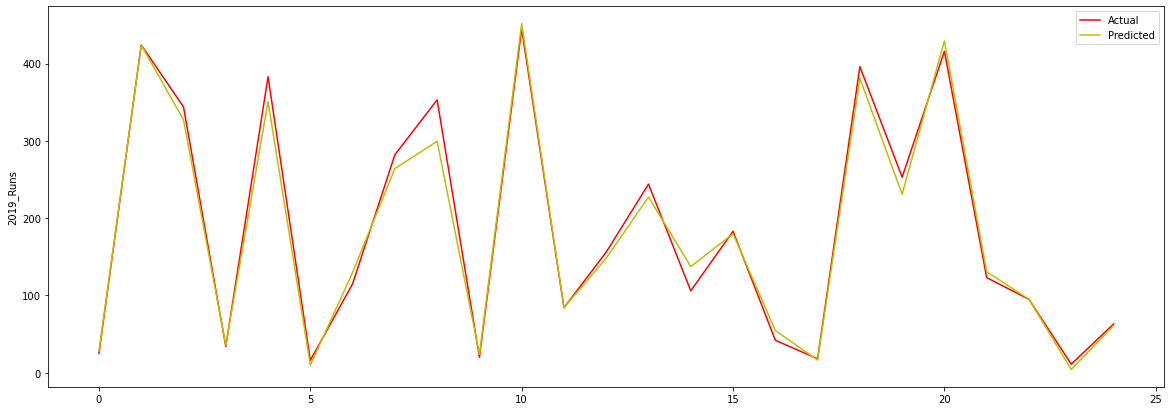

In [266]:
plt.figure(figsize=(20,7))
sns.lineplot(x=range(len(X_test)),y=y_test,color='r',label='Actual')
sns.lineplot(x=range(len(X_test)),y=lr.predict(ss.transform(X_test.iloc[:,1:]))*.5+lgb_cl.predict(X_test.iloc[:,1:])*.5,color='y',label='Predicted')
plt.legend()

###  Final model training

In [246]:
feature.head()

,PLAYER,Inns,NO,2018_Runs,HS,Avg,BF,SR,100,50,4s,6s,Runs_by_boundry,%Runs by boundry,Avg_b
0,Aaron Finch,9,1,134,46,16.75,100,134.00,0,0,6,8,72,53.73,8.00
1,AB de Villiers,11,2,480,90,53.33,275,174.54,0,6,39,30,336,70.00,30.55
2,Abhishek Sharma,3,2,63,46,63.00,33,190.90,0,0,3,5,42,66.67,14.00
3,Ajinkya Rahane,14,1,370,65,28.46,313,118.21,0,1,39,5,186,50.27,13.29
4,Alex Hales,6,0,148,45,24.66,118,125.42,0,0,13,6,88,59.46,14.67


In [247]:
dtrain=lgb.Dataset(feature.iloc[:,1:],label)
feature_scaled=ss.fit_transform(feature.iloc[:,1:])

In [248]:
lgb_cl=lgb.train(params,dtrain,num_boost_round=1293)
lr.fit(feature_scaled,label)

Lasso()

### Pipeline

In [269]:
class model:
    def __init__(self):
        self.feature=np.nan
        self.feature_scaled=np.nan
    def mining(self,feature):
        feature.drop(['PLAYER','Mat'],axis=1,inplace=True)
        feature.Avg=feature.Avg.replace({'-',100}).astype(float)
        feature.HS=feature['HS'].map(str).str.replace('*','').astype(int)
        return feature

    def feature_gen(self,feature):
        feature['Runs_by_boundry']=feature['4s']*4+6*feature['6s']
        feature['%Runs by boundry']=np.round(feature.Runs_by_boundry/feature['2018_Runs']*100,2)
        feature['Avg_b']=np.round(feature.Runs_by_boundry/feature.Inns,2)
        return feature
    def predict(self,feature):
        self.feature=feature
        self.feature=self.mining(self.feature)
        self.feature=self.feature_gen(self.feature)
        self.feature_scaled=ss.transform(feature)
        #print(self.feature.columns)
        return lgb_cl.predict(self.feature)*.5+lr.predict(feature_scaled)*.5

In [272]:
md=model()
md.predict(train.drop('2019_Runs',axis=1))

array([ 1.47057158e+02,  4.28926399e+02,  5.89245246e+01,  3.85352918e+02,
        1.54116942e+02,  4.97727401e+02,  3.01229728e+02,  2.85957759e+01,
        7.87297830e+01,  9.11911408e+01,  2.00420040e+02,  1.04060214e+00,
        1.33613405e+02,  7.19376628e+01,  4.01961204e+02,  4.60066375e+02,
        2.49635395e+01,  5.07264088e+00,  1.35394715e+02,  6.17162077e+01,
        2.12584666e+00,  6.91658470e+00,  1.13341329e+02,  5.87644806e+01,
        3.33539826e+01,  8.24174535e+01,  4.43601860e+02,  1.60961167e+02,
        4.04893870e+02,  1.83658700e+02,  8.63986872e+01,  1.79363077e+02,
        1.36657927e+01,  2.85966916e+02,  6.39637125e+01,  4.55541776e+01,
        3.07309678e+02,  1.36826883e+02,  3.94657464e+01,  1.90665928e+01,
        4.62044948e+02,  2.09777186e+01,  5.46994024e+02,  3.29715533e+02,
        2.18446125e+01,  1.47257651e+02,  5.10185531e+02,  1.28753278e+02,
        2.31440037e+02, -8.28239736e-01,  5.23569524e+01,  2.65218550e+02,
        3.18033580e+02,  